# Functional Python
## ref.
1. https://kachayev.github.io/talks/uapycon2012/#/28
https://github.com/mpkocher/Functional-Programming-Techniques-In-Python/tree/main
2. https://github.com/sfermigier/awesome-functional-python
3. https://ep2021.europython.eu/media/conference/slides/5SQrJC4-functional-programming-inside-oop-its-possible-with-python.pdf
4. https://ep2021.europython.eu/media/conference/slides/a-hitchhikers-guide-to-functools.pdf
5. https://speakerdeck.com/kachayev/monadic-parsing-in-python?slide=43 [advanced]
6. https://github.com/PacktPublishing/Functional-Python-Programming-Second-Edition
7. https://github.com/mpkocher/Functional-Programming-Techniques-In-Python




## takeaway
1. 避免使用class for easy debug, immutablity, avoid attributes to set or change,
2. 想象没有dict的场景
3. Function as high-class
4. Function as parameter and return object
5. Decorator
6. reduce, map, imap, filter, sort, itertools, chain, reverse, partial, xpartial(customized, right partial)
7. do the pipeline gracefully with pipetools


In [2]:
from operator import itemgetter
itemgetter(0, 1, 2)('ABCDEFG')


('A', 'B', 'C')

如果从func as return 角度理解，decorator非常简单
```python
def decorator(fn):
    def inner(*arg, **kwargs):
        ...
        fn(*arg, **kwargs)
        ...
    return inner

decorator(fn) -> is inner --> inner(*args, **kwargs) is quite natural
```

如果是接受参数的decorator呢？
```python
def decorator(*args, **kwargs):
    def inner(fn):
        ...
        fn(*args, **kwargs)
        ...
    return inner

```
显然不对，因为decorator没有接受fn参数。decorator如果先接受了自己的参数，那么还需要返回inner decorator接受fn
```python
def outer_decorator(*args, **kwargs):
    def inner_decorator(fn):
        def core_fn(*args, **kwargs):
            ...
            fn(*args, **kwargs)
            ...
        return core_fn # 返回fn执行结果
    return inner_decorator # 返回 decorator(fn)
```

In [ ]:
# avoid loop and while
def get_name():
    name = raw_input()
    return name if len(name) >= 2 else get_name()

# avoid for
xprint = lambda x: print(f'=> {x}')
map(xprint, range(5))

filter(lambda x: x>2, range(10))

from itertools import chain
chain(range(10), range(3),)

# yield something to be lazy
def foo():
    yield 1

from functools import reduce
import operator
ss = ["UA", "PyCon", "2012"]
reduce(operator.add, map(len, ss))


In [27]:
# use partial to construct functions
def greet(greeting, target):
    return "{greet}! {name}".format(name=target, greet=greeting, )
import functools
hola = functools.partial(greet, "hola")
hola('Andrey')

In [20]:
# `partial`使用**kwargs
def say_hi(**kwargs):
    print(kwargs['name'], kwargs['something'], kwargs['question'])

# wrong:
# say_morning = partial(say_hi, dict(name='John', something='morning!'))

# correct
# prompt: use partial to create new function  of say_hi with parameters dict(name='John', something='morning')
import functools
say_morning = functools.partial(say_hi, **dict(name='John', something='morning'))
say_morning(question='how areyou doing?')

# `partial` 仅限于第一个left参数，不能跳过; 连带输入参数名可以实现指定参数达到kwargs效果
# credit https://stackoverflow.com/questions/60496556/how-to-specify-arg-position-for-functool-partial

def add_minus_compund(x, y, z):
    return ((x+3) - y) ** z

comp = functools.partial(add_minus_compund, x=1, y=1)
# comp(3) got TypeError: add_minus_compund() got multiple values for argument 'x'
# since the para already named, so you have to continue
comp(z=3)

John morning how areyou doing?


27

In [17]:
# compose the functions
from functools import reduce

def compose(*funcs):
    def compose_tow(f, g):
        def c(x):
            return g(f(x))
        return c
    return reduce(compose_tow, funcs)

from functools import partial
add_1 = partial(operator.add, 1)
mul = lambda x: x*5
f = compose(add_1, add_1, mul)
f2 = compose(mul, add_1, add_1)
f(1), f2(1)




John morning how areyou doing?


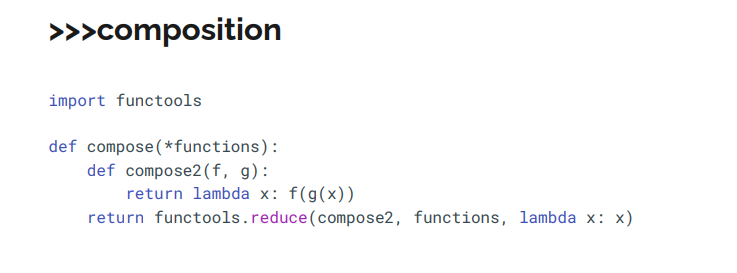

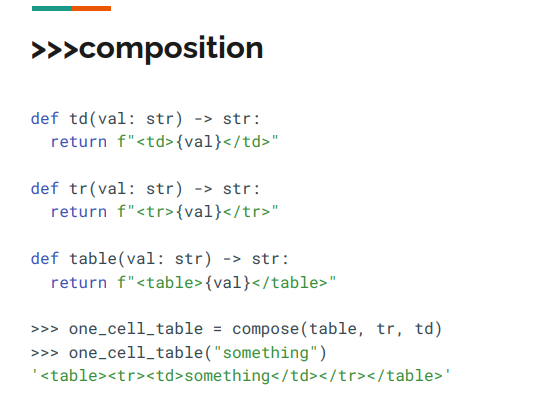

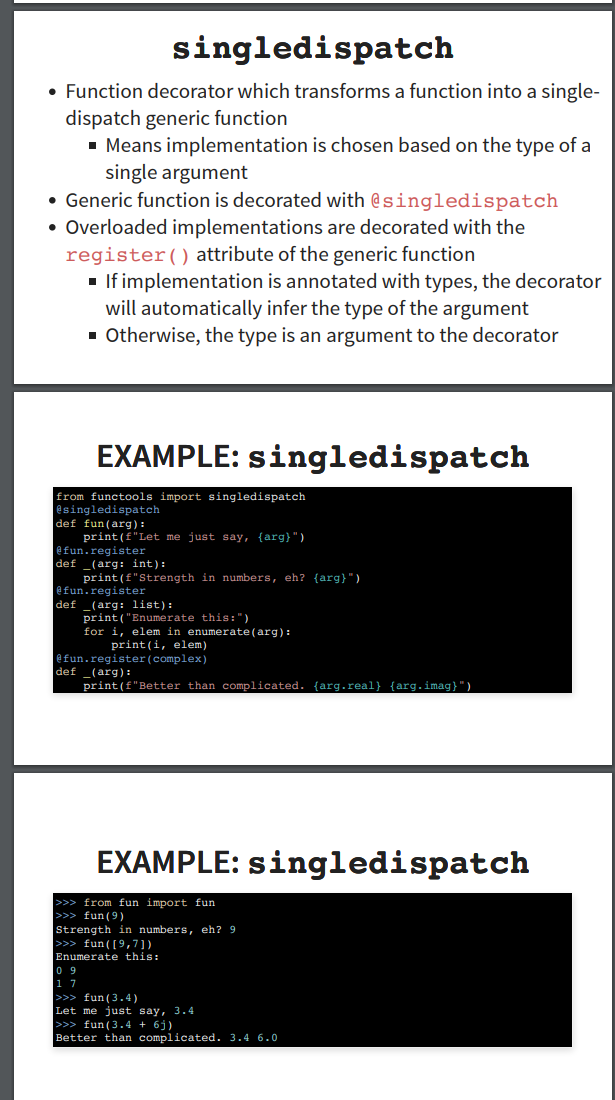

In [ ]:
# the singledispatch over-load the function behavior via the input parameter type
# while, it is kind of adapter when the upstream output is not so solid enough
# use compose to produce new function in stead, way better


In [ ]:
# 用compose func 并不是很便利，每次都要定义新函数，很多时候是很自然发生的，再写函数显得多余
# 引入pipetools
!pip install pipetools


In [51]:
from pipetools import pipe, where, sort_by, foreach, X
import os
print(os.getcwd())
pyfiles_by_length = (pipe
    | os.listdir
    | sort_by(len).descending
    | (enumerate, X, 1)
    | foreach("{0}. {1}")
    | '\n'.join)
# pipe用来构造新函数，本身并不执行
# 接受args，例如os.lisdir
# 接受kwargs，例如sort_by (sorted的改进版)
# X 是

/content


In [34]:
from functools import partial
odd_sum = pipe | range | partial(filter, lambda x: x % 2) | sum
odd_sum = pipe | range | (filter, lambda x: x % 2) | sum # 如果pipe是一个tuple，自动认为是partial，节约字符
odd_sum = pipe | range | where(lambda x: x % 2) | sum # where 类似filter，不过更直观，可以理解为条件
odd_sum = range | where(lambda x: x % 2) | sum # 第1/2个pipe作为输入时，可以省略掉
odd_sum = range | where(X % 2) | sum # 使用X魔法来替换掉lambda函数
odd_sum(10)

25

In [52]:
print_dir = pipe | os.listdir | partial(sorted, key=lambda x: len(x)) | (enumerate, X, 1) | foreach("{0}. {1}") | '\n'.join
print(print_dir('.'))


1. .config
2. test.py
3. sample_data
4. .ipynb_checkpoints


In [56]:
# 不能直接带入结果使用pipe，只操作函数，比如下面会报错
pipe | os.listdir('.') | partial(sorted, key=lambda x: len(x)) | (enumerate, X, 1) | foreach("{0}. {1}") | '\n'.join


ValueError: Cannot pipe ['.config', '.ipynb_checkpoints', 'test.py', 'sample_data']

In [58]:
# OK
"." > pipe | os.listdir | partial(sorted, key=lambda x: len(x)) | (enumerate, X, 1) | foreach("{0}. {1}") | '\n'.join

# also ok
(pipe | os.listdir | partial(sorted, key=lambda x: len(x)) | (enumerate, X, 1) | foreach("{0}. {1}") | '\n'.join)(".")

'1. .config\n2. test.py\n3. sample_data\n4. .ipynb_checkpoints'

In [ ]:
# 有了pipe，partial，参数partial，kwargs partial 组合多了起来，同时

In [ ]:
# 除此之外，operator, len, sorted, reversed, map, reduce, iterate, getattr 也是函数常用方法

In [59]:
map(str, range(5))

In [61]:
# class is mappable
class Speaker(object):
     def __init__(self, name):
         self.name = name
map(Speaker, ["Alexey", "Andrey", "Vsevolod"])


In [62]:
# method is mappable
map([1,2,3,4,5].count, [1,2,3,10,11])

In [65]:
# operator has plenty of functioning style
import operator
dir(operator)

['__abs__',
 '__add__',
 '__all__',
 '__and__',
 '__builtins__',
 '__cached__',
 '__concat__',
 '__contains__',
 '__delitem__',
 '__doc__',
 '__eq__',
 '__file__',
 '__floordiv__',
 '__ge__',
 '__getitem__',
 '__gt__',
 '__iadd__',
 '__iand__',
 '__iconcat__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__inv__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__loader__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__name__',
 '__ne__',
 '__neg__',
 '__not__',
 '__or__',
 '__package__',
 '__pos__',
 '__pow__',
 '__rshift__',
 '__setitem__',
 '__spec__',
 '__sub__',
 '__truediv__',
 '__xor__',
 '_abs',
 'abs',
 'add',
 'and_',
 'attrgetter',
 'concat',
 'contains',
 'countOf',
 'delitem',
 'eq',
 'floordiv',
 'ge',
 'getitem',
 'gt',
 'iadd',
 'iand',
 'iconcat',
 'ifloordiv',
 'ilshift',
 'imatmul',
 'imod',
 'imul',
 'index',
 'indexOf',
 'inv',
 'inv

In [ ]:
# think functioning, not class
# data goes through the pipe and get exact result with speicific input
#